In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import time
import pandas as pd
from multiprocessing import Pool, Manager
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import col, count, lit, abs as F_abs, broadcast
from pyspark.storagelevel import StorageLevel
import networkx as nx
import matplotlib.pyplot as plt

# Crawler function to create the a directed edge list

Function:
1. Helper function is_valid_url() - returns if the given url is within the domain
2. Main function crawl_website() - crawl through all links and create a directed edge list with the number of pairs limited by the parameter n given beforehand, if n is null, crawl through all valid urls. Saves the url pairs as url_pairs.csv


In [ ]:
def is_valid_url(url, domain="it.tdtu.edu.vn"):
    """Check if URL is HTTPS, within the domain, and not a static file."""
    from urllib.parse import urlparse
    parsed = urlparse(url)
    # Check if the scheme is HTTPS
    if parsed.scheme != 'https':
        return False
    # Check if the URL belongs to the specified domain
    if domain not in parsed.netloc:
        return False
    # Exclude static files
    static_extensions = ('.jpg', '.png', '.gif', '.pdf', '.css', '.js', '.ico', '.mp4', '.mp3')
    return not url.lower().endswith(static_extensions)

def crawl_website(start_url="https://it.tdtu.edu.vn", output_csv="url_pairs.csv", n=None):
    """Crawl the website, collect up to n unique (source, destination) HTTPS URL pairs, and save to CSV."""
    # Validate start_url scheme
    parsed_start = urlparse(start_url)
    if parsed_start.scheme != 'https':
        print(f"Error: Start URL {start_url} must use HTTPS.")
        return set()

    visited = set()
    to_visit = [start_url]
    url_pairs = set()  # Use a set to avoid duplicate edges
    headers = {'User-Agent': 'Mozilla/5.0'}

    while to_visit and (n is None or len(url_pairs) < n):
        current_url = to_visit.pop(0)
        if current_url in visited:
            continue

        try:
            response = requests.get(current_url, headers=headers, timeout=5)
            if response.status_code != 200:
                continue
            soup = BeautifulSoup(response.text, 'html.parser')
            visited.add(current_url)

            # Extract all links
            for link in soup.find_all('a', href=True):
                href = link['href']
                absolute_url = urljoin(current_url, href).split('#')[0]  # Remove fragments
                if is_valid_url(absolute_url) and (n is None or len(url_pairs) < n):
                    url_pairs.add((current_url, absolute_url))  # Add edge as a tuple to the set
                    if absolute_url not in visited and absolute_url not in to_visit:
                        to_visit.append(absolute_url)

            print(f"Crawled: {current_url}, Total unique links found so far: {len(url_pairs)}")
            time.sleep(1)  # Be polite to the server

        except Exception as e:
            print(f"Error crawling {current_url}: {e}")

    # Save URL pairs to CSV
    if url_pairs:
        df = pd.DataFrame(list(url_pairs), columns=['source', 'destination'])
        df.to_csv(output_csv, index=False, encoding='utf-8')
        print(f"Saved {len(url_pairs)} unique URL pairs to {output_csv}")
    else:
        print("No URL pairs collected. CSV file not created.")

    return url_pairs

# PageRank class


## Definition of the PageRank algorithm

Contains the following functions:
1. The __init__() function: assigning the necessary variables needed for running the PageRank algorithm, with some default values if users wants a simple visualization after running the algorithm.

2. The compute_pagerank() function:

In [ ]:
# PageRank class
class PageRank:
    def __init__(self, edges_df, damping_factor=0.85, max_iter=10, tol=1e-4):
        self.edges_df = edges_df
        self.damping_factor = damping_factor
        self.max_iter = max_iter
        self.tol = tol
        self.spark = edges_df.sparkSession


    def compute_pagerank(self):
        self.spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoints")
        pages = self.edges_df.select("source").union(self.edges_df.select("destination")).distinct()
        N = pages.count()

        diff_record = []
        if N == 0:
            return self.spark.createDataFrame([], schema=StructType([
                StructField("page", StringType(), True),
                StructField("rank", StringType(), True)
            ]))
        ranks = pages.select(col("source").alias("page"), lit(1.0 / N).alias("rank"))
        ranks.persist(StorageLevel.DISK_ONLY)
        out_degrees = self.edges_df.groupBy("source").agg(count("destination").alias("out_degree"))
        out_degrees.persist(StorageLevel.DISK_ONLY)

        for iteration in range(self.max_iter):
            print(f"Iteration {iteration + 1}")
            contributions = self.edges_df.join(broadcast(ranks), self.edges_df.source == ranks.page) \
                .join(broadcast(out_degrees), self.edges_df.source == out_degrees.source) \
                .select(
                    self.edges_df.destination.alias("page"),
                    (col("rank") / col("out_degree")).alias("contribution")
                )
            new_ranks = contributions.groupBy("page").agg({"contribution": "sum"}) \
                .select(
                    col("page"),
                    (lit((1 - self.damping_factor) / N) + lit(self.damping_factor) * col("sum(contribution)")).alias("rank")
                )
            all_pages = pages.select(col("source").alias("page"))
            new_ranks = all_pages.join(new_ranks, "page", "left_outer") \
                .select(col("page"), col("rank").alias("new_rank"))
            new_ranks = new_ranks.na.fill({"new_rank": (1 - self.damping_factor) / N})
            diff = ranks.join(new_ranks, "page") \
                .select(F_abs(col("rank") - col("new_rank")).alias("diff")) \
                .agg({"diff": "max"}).collect()[0][0]
            print(f"Max rank difference: {diff}")
            diff_record.append(diff)
            if diff < self.tol:
                print("Converged.")
                break
            ranks = new_ranks.select(col("page"), col("new_rank").alias("rank"))
            if (iteration + 1) % 3 == 0:
                ranks = ranks.checkpoint()
        ranks.unpersist()
        out_degrees.unpersist()
        visualize_diff(diff_record)
        return ranks



## Visualization function to see the top 20 sites with the highest rank

In [ ]:
# Visualization function for top 20 sites
def visualize_top_pages(edges_df, ranks_df, top_n=20, output_file="/content/top_pages_graph.png"):
    """Visualize top N pages by PageRank as a directed graph."""
    # Get top N pages
    top_pages = ranks_df.orderBy(col("rank").desc()).limit(top_n)
    top_pages_list = [row['page'] for row in top_pages.collect()]

    # Filter edges
    top_edges = edges_df.filter(
        col("source").isin(top_pages_list) & col("destination").isin(top_pages_list)
    ).collect()

    # Get ranks for sizing
    rank_dict = {row['page']: row['rank'] for row in top_pages.collect()}

    # Create graph
    G = nx.DiGraph()
    for page in top_pages_list:
        G.add_node(page, rank=rank_dict[page])
    for edge in top_edges:
        G.add_edge(edge['source'], edge['destination'])

    # Layout
    pos = nx.spring_layout(G, k=1.5, iterations=50)

    # Node sizes
    node_sizes = [rank_dict[page] * 100000 for page in G.nodes()]

    # Shorten labels
    labels = {page: page.split('/')[-2] if page.split('/')[-1] == '' else page.split('/')[-1] for page in G.nodes()}

    # Draw graph
    plt.figure(figsize=(12, 12))
    nx.draw(
        G, pos,
        with_labels=False,
        node_size=node_sizes,
        node_color='lightblue',
        font_size=8,
        font_weight='bold',
        arrows=True,
        arrowstyle='->',
        arrowsize=15,
        edge_color='gray'
    )
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')
    plt.title(f"Top {top_n} Pages by PageRank", fontsize=14)
    plt.savefig(output_file, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Graph saved to {output_file}")

    # Write the top 20 pages to a CSV file
    top_pages.write.csv("/content/top_pages.csv", mode="overwrite", header=True)

def visualize_diff(diff_record):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(diff_record) + 1), diff_record, marker='o', linestyle='-')
    plt.title('Max Rank Difference Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Max Rank Difference')
    plt.grid(True)
    plt.show()

In [ ]:
def main():
  # Initialize Spark session for large datasets
  spark = SparkSession.builder \
      .appName("Task4") \
      .config("spark.driver.memory", "8g") \
      .config("spark.executor.memory", "16g") \
      .config("spark.sql.shuffle.partitions", "1000") \
      .config("spark.memory.fraction", "0.75") \
      .config("spark.shuffle.memoryFraction", "0.3") \
      .config("spark.sql.adaptive.enabled", "true") \
      .config("spark.default.parallelism", "1000") \
      .getOrCreate()

  # Load CSV into DataFrame
  schema = StructType([
      StructField("source", StringType(), True),
      StructField("destination", StringType(), True)
  ])

  # Crawl the website and save to CSV
  start_url = "https://it.tdtu.edu.vn"
  url_pairs = crawl_website(start_url, output_csv="url_pairs.csv")
  print(f"Total unique URL pairs collected: {len(url_pairs)}")

  edges_df = spark.read.csv("/content/url_pairs.csv", header=True, schema=schema)

  # Deduplicate and persist to disk
  edges_df = edges_df.dropDuplicates(["source", "destination"]).repartition(1000, "source")
  edges_df.persist(StorageLevel.DISK_ONLY)

  # Compute PageRank
  pagerank = PageRank(edges_df)
  ranks_df = pagerank.compute_pagerank()

  # Visualize top 10 pages
  visualize_top_pages(edges_df, ranks_df, top_n=10, output_file="/content/top_pages_graph.png")

  # Sort and save results
  ranks_df = ranks_df.orderBy(col("rank").desc()).cache()
  ranks_df.write.csv("/content/pagerank_results", mode="overwrite")

  # Get most important page
  most_important_page = ranks_df.head(5)[0]
  for page in ranks_df.head(5):
    print(page)
  print(f"Most important page: {most_important_page['page']} with rank {most_important_page['rank']}")

  # Clean up
  edges_df.unpersist()
  spark.stop()

Crawled: https://it.tdtu.edu.vn, Total unique links found so far: 43
Crawled: https://it.tdtu.edu.vn/en, Total unique links found so far: 79
Crawled: https://it.tdtu.edu.vn/giao-vien, Total unique links found so far: 97
Crawled: https://it.tdtu.edu.vn/, Total unique links found so far: 139
Crawled: https://it.tdtu.edu.vn/gioi-thieu, Total unique links found so far: 186
Crawled: https://it.tdtu.edu.vn/giao-duc, Total unique links found so far: 207
Crawled: https://it.tdtu.edu.vn/khoa-hoc-cong-nghe, Total unique links found so far: 232
Crawled: https://it.tdtu.edu.vn/tin-tuc-khoa, Total unique links found so far: 265
Crawled: https://it.tdtu.edu.vn/doanh-nghiep, Total unique links found so far: 285
Crawled: https://it.tdtu.edu.vn/tuyen-sinh, Total unique links found so far: 307
Crawled: https://it.tdtu.edu.vn/iccies, Total unique links found so far: 308
Crawled: https://it.tdtu.edu.vn/tuyen-sinh/thac-si-nganh-khoa-hoc-may-tinh, Total unique links found so far: 329
Crawled: https://it.tdt

<ipython-input-2-8b5a01a50c82>:37: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(response.text, 'html.parser')


Crawled: https://it.tdtu.edu.vn/taxonomy/term/68/feed, Total unique links found so far: 3256
Crawled: https://it.tdtu.edu.vn/taxonomy/term/65, Total unique links found so far: 3294
Crawled: https://it.tdtu.edu.vn/taxonomy/term/92, Total unique links found so far: 3312
Crawled: https://it.tdtu.edu.vn/user/login?destination=/vong-chung-ket-cuoc-thi-tech-startup-challenger-2025-be-phong-cho-nhung-y-tuong-khoi-nghiep-cong%23comment-form, Total unique links found so far: 3329
Crawled: https://it.tdtu.edu.vn/user/login?destination=/khai-mac-giai-bong-da-khoa-cong-nghe-thong-tin-khoa-my-thuat-cong-nghiep-nam-2025%23comment-form, Total unique links found so far: 3346
Crawled: https://it.tdtu.edu.vn/user/login?destination=/ngay-hoi-sinh-vien-it-doanh-nghiep-it-career-day-2025-ket-noi-va-dinh-huong-tuong-lai%23comment-form, Total unique links found so far: 3363
Crawled: https://it.tdtu.edu.vn/taxonomy/term/85, Total unique links found so far: 3385
Crawled: https://it.tdtu.edu.vn/user/login?desti

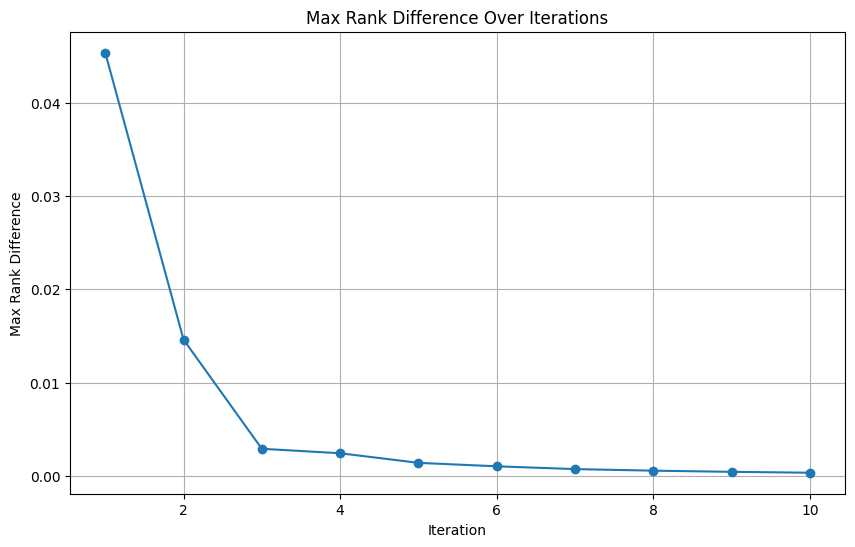

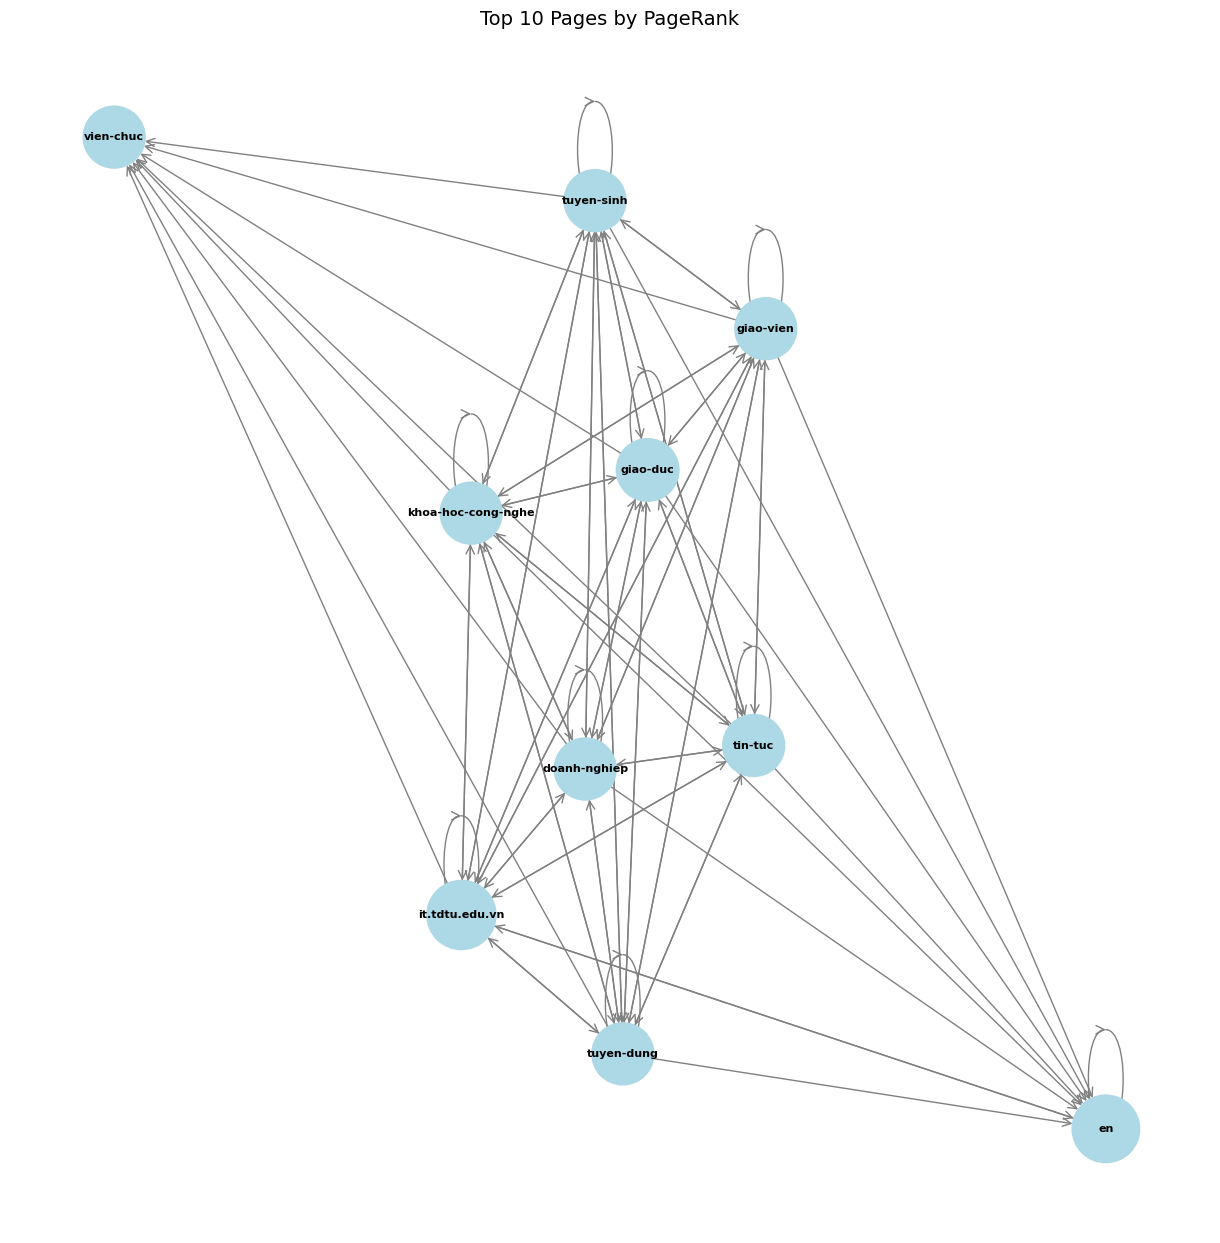

Graph saved to /content/top_pages_graph.png
Row(page='https://it.tdtu.edu.vn/', rank=0.02479144794820049)
Row(page='https://it.tdtu.edu.vn/en', rank=0.023642990096844535)
Row(page='https://it.tdtu.edu.vn/giao-duc', rank=0.020306938524208996)
Row(page='https://it.tdtu.edu.vn/giao-vien', rank=0.019905923019873307)
Row(page='https://it.tdtu.edu.vn/doanh-nghiep', rank=0.019905923019873307)
Most important page: https://it.tdtu.edu.vn/ with rank 0.02479144794820049


In [ ]:
main()